In [1]:
from ipynb.fs.full.Tokyo_V2 import *

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [2]:
from collections import OrderedDict,Counter
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm
             
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight
        
        """return top number keywords"""
        kw = []
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
           # print(key + ' - ' + str(value))
            if value > 1:
                kw.append(key)
        return ' '.join(kw)


In [3]:
tr4w = TextRank4Keyword()
analyser = lambda x: tr4w.analyze(x, candidate_pos = ['NOUN', 'PROPN'], window_size=5, lower=False)

In [4]:
listings_clean['summary'] = listings_clean['summary'].dropna()

In [5]:
listings_clean['KW'] = listings_clean['summary'].apply(analyser)

In [6]:
# convert to lower case, remove numbers and punctuation and strip non-ASCII characters
import re
import string
listings_clean['KW'] = listings_clean['KW'].apply(lambda x:str.lower(x))
listings_clean['KW'] = listings_clean['KW'].apply(lambda x:re.sub("([^\x00-\x7F])+"," ",x))
listings_clean['KW'] = listings_clean['KW'].apply(lambda x:x.translate(str.maketrans('', '', string.punctuation)))
listings_clean['KW'] = listings_clean['KW'].apply(lambda x:''.join(i for i in x if not i.isdigit()))

In [7]:
# Join all summries to single string and then find the count of most repeated words. 
words = (listings_clean['KW'].str.cat(sep=" ")).split()
word_counts = Counter(words)
for word, count in word_counts.most_common():
    if count > 25:
        print(f'{word} is repeated {count} times.')

station is repeated 3219 times.
tokyo is repeated 2126 times.
room is repeated 2012 times.
shinjuku is repeated 1510 times.
line is repeated 1211 times.
minutes is repeated 1087 times.
house is repeated 1011 times.
min is repeated 988 times.
walk is repeated 888 times.
asakusa is repeated 735 times.
area is repeated 704 times.
bed is repeated 689 times.
jr is repeated 688 times.
apartment is repeated 659 times.
mins is repeated 657 times.
airport is repeated 657 times.
ikebukuro is repeated 642 times.
access is repeated 632 times.
shibuya is repeated 590 times.
stores is repeated 551 times.
restaurants is repeated 546 times.
shopping is repeated 526 times.
kitchen is repeated 512 times.
ueno is repeated 505 times.
convenience is repeated 483 times.
rooms is repeated 472 times.
akihabara is repeated 466 times.
train is repeated 446 times.
hotel is repeated 426 times.
haneda is repeated 421 times.
floor is repeated 410 times.
bathroom is repeated 404 times.
ginza is repeated 374 times.
f

# Add below features
is close to station,train,yamanote
is in shinjuku 
is in asakusa
close to airport, haneda, narita
is close to ikebukuro?
close to shibuya?
close to ueno?
akihabara,ginza,roppongi,harajuku,temple,shrine,okubo,Otsuka,nishi,tsukiji,ryogoku,shinagawa,kaminarimon,akasaka,ikebukuro


In [8]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

In [9]:
def show_wordcloud(data, title = None):
    
    
    '''funtion to produce and display wordcloud
        taken 2 arguments
        1.data to produce wordcloud
        2.title of wordcloud'''
    
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=250,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud,interpolation="bilinear")
    plt.show()

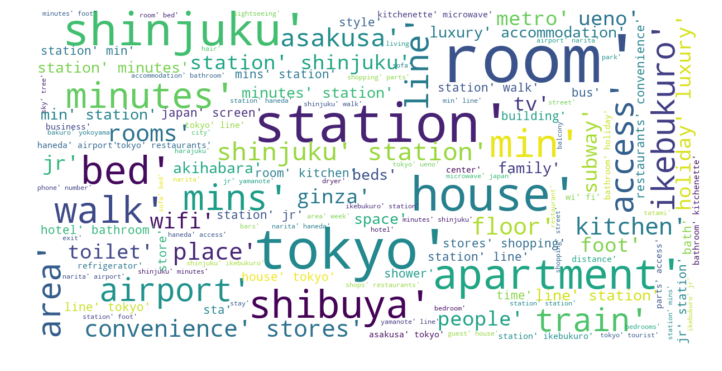

In [10]:
show_wordcloud(words)

In [11]:
listings_clean['KW']=listings_clean['KW'].apply(lambda x:x.split())

In [12]:
# add new features based on NLP analysis above.
listings_clean['shinjuku']=listings_clean['KW'].apply(lambda x:1 if ('shinjuku') in x else 0)
listings_clean['asakusa']=listings_clean['KW'].apply(lambda x:1 if ('asakusa') in x else 0)
listings_clean['ikebukuro']=listings_clean['KW'].apply(lambda x:1 if ('ikebukuro') in x else 0)
listings_clean['shibuya']=listings_clean['KW'].apply(lambda x:1 if ('shibuya') in x else 0)
listings_clean['ueno']=listings_clean['KW'].apply(lambda x:1 if ('ueno') in x else 0)

In [13]:
listings_clean['station'] = listings_clean['KW'].apply(lambda x:any(item in x for item in 
                                                                     ['station','train','yamanote']))

In [14]:
listings_clean['airport'] = listings_clean['KW'].apply(lambda x:any(item in x for item in 
                                                                     ['airport','haneda','narita']))
listings_clean['attractions']=listings_clean['KW'].apply(lambda x:any(item in x for item in 
                                                                      ['akihabara','ginza','roppongi',
                                                                       'harajuku','temple','shrine','okubo',
                                                                       'Otsuka','nishi','tsukiji','ryogoku',
                                                                       'shinagawa','kaminarimon','akasaka',
                                                                        'ikebukuro']))

In [15]:
listings_clean.replace({False: 0, True: 1}, inplace=True)

In [16]:
listings_clean = listings_clean.drop(columns = ['KW','summary'],axis=1)

In [17]:
listings_clean.shape

(10601, 109)

In [20]:
listings_clean['host_response_rate'].value_counts()

100%      8402
95-99%    1272
90-94%     464
80-89%     247
50-79%     197
0-49%       19
Name: host_response_rate, dtype: int64